In [1]:
import os

# 0 = all logs, 1 = filter out INFO, 2 = filter out INFO+WARNING, 3 = only errors
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Optional: prevent verbose vlogs
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "0"


# Importing Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
# !pip install tensorflow

In [4]:
# !pip install matplotlib

# Checking versions

In [5]:
print(tf.__version__)
print(plt.matplotlib.__version__)

import matplotlib
print(matplotlib.__version__)

2.20.0
3.10.6
3.10.6


# Defining Constants

In [6]:
IMAGE_SIZE=128 #it is seen by choosing one image that can be any from the dataset then rightclick and see its properties > detail and we can see height and width or simply dimensions
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

# Load data into tf Dataset

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory="Dataset",
    seed=123,
    shuffle= True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 8982 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['mask_weared_incorrect', 'with_mask', 'without_mask']

In [9]:
len(dataset) #It is showing 281 cause every element in the dataset is actually the batch of 32 images 

281

In [10]:
281*32 # It shows the complete number of images in the dataset

8992

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(type(image_batch))
    print(label_batch.numpy())

(32, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
[0 0 2 2 2 2 2 2 1 2 0 0 0 1 1 0 1 2 0 1 0 1 1 1 1 1 2 2 2 2 1 0]


# Data Visualization

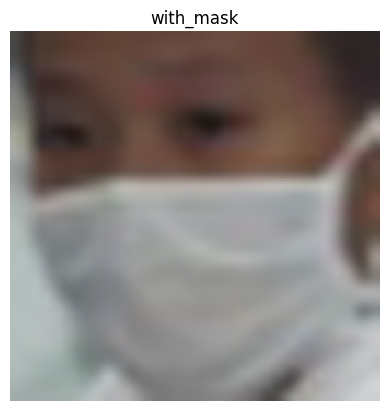

In [12]:
for image_batch, label_batch in dataset.take(1):  #everytime shows new image as it is shuffling
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

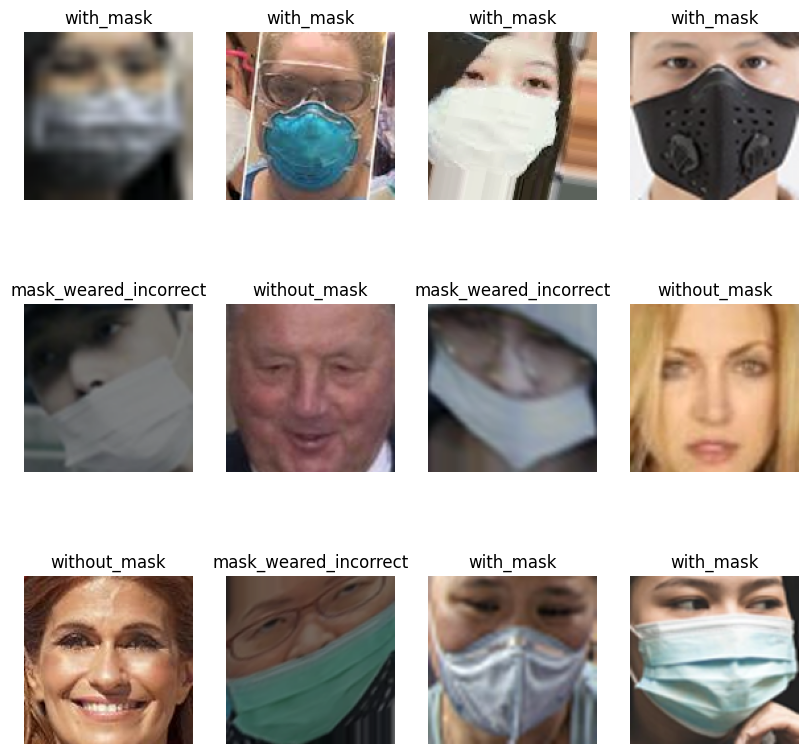

In [13]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): 
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Train Test Split

## I have done
- 80% for training, 
- remaining 20% -> 10% for validation and 10% for test 

#### Training Dataset

In [14]:
train_size=0.8
len(dataset)*train_size

224.8

In [15]:
train_ds = dataset.take(224)
len(train_ds)

224

#### Testing and validation split from remaining 20%

In [16]:
test_ds = dataset.skip(224)
len(test_ds)

57

In [17]:
len(dataset)

281

In [18]:
val_size=0.1
len(dataset)*val_size

28.1

#### Validation Dataset

In [19]:
val_ds=test_ds.take(28)
len(val_ds)

28

#### Testing Dataset

In [20]:
test_ds=test_ds.skip(28)
len(test_ds)

29

### Wrapping everything what I have written so far in cells for train val and test split into a function 

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

224

In [24]:
len(val_ds)

28

In [25]:
len(test_ds)

29

### Cache, Shuffle, and Prefetch the Dataset

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #if gpu is busy training, then prefetch will load the next set of batch from the disk
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Augmentation

In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Building Model

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

In [30]:
model =models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])
model.build(input_shape=input_shape)

C:\Users\nisch\Jupyter_Codes\mask wearing classification\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 128, 128, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 128, 128, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 126, 126, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 63, 63, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 61, 61, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146,819 (573.51 KB)

 Trainable params: 146,819 (573.51 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

In [33]:
# history = model.fit(
#     train_ds,
#     batch_size=BATCH_SIZE,
#     validation_data=val_ds,
#     verbose=1,
#     epochs=50,
# )

# Load the model

I am loading the model as i have trained the model in kaggle

In [34]:
model = tf.keras.models.load_model("../models/2_model_training_earlystopping/my_model_earlystopping.keras")
# model = tf.keras.models.load_model("../models/1_model_training_100epochs/1.keras")

# Accuracy and loss on test datasets

In [35]:
scores = model.evaluate(test_ds)

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9914 - loss: 0.0194


In [36]:
scores

[0.019445935264229774, 0.9913793206214905]

# Plotting graphs and loading pickle file

In [37]:
# history.keys()

In [46]:
import pickle  #the pickle file is also loaded as history during model training is needed to plot graphs

with open("../models/2_model_training_earlystopping/history_earlystopping.pkl", "rb") as f:
    history = pickle.load(f)

print(history.keys())  # dict keys: loss, accuracy, val_loss, val_accuracy


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [47]:
history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [48]:
type(history['loss'])

list

In [49]:
len(history['loss'])

42

In [50]:
# Loss
train_loss = history['loss']
val_loss   = history['val_loss']

# Accuracy
train_acc = history['accuracy']
val_acc   = history['val_accuracy']

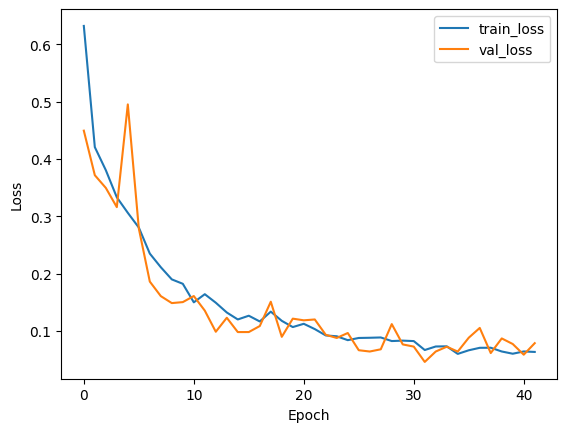

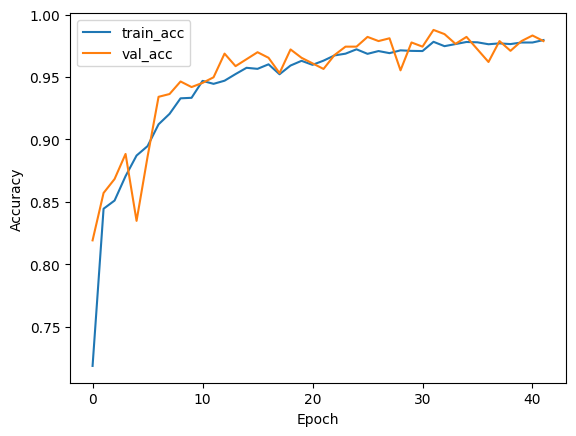

In [51]:
import matplotlib.pyplot as plt

# Loss plot
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Running Predictions on sample Image

Image for prediction
actual label: without_mask
---------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
predicted label: without_mask


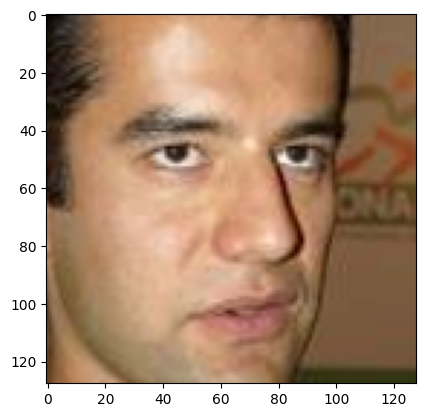

In [52]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Image for prediction")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    print("---------------------------")
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Writing a function for inference

In machine learning / deep learning, inference is:

The process of using a trained model to make predictions on new, unseen data.

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


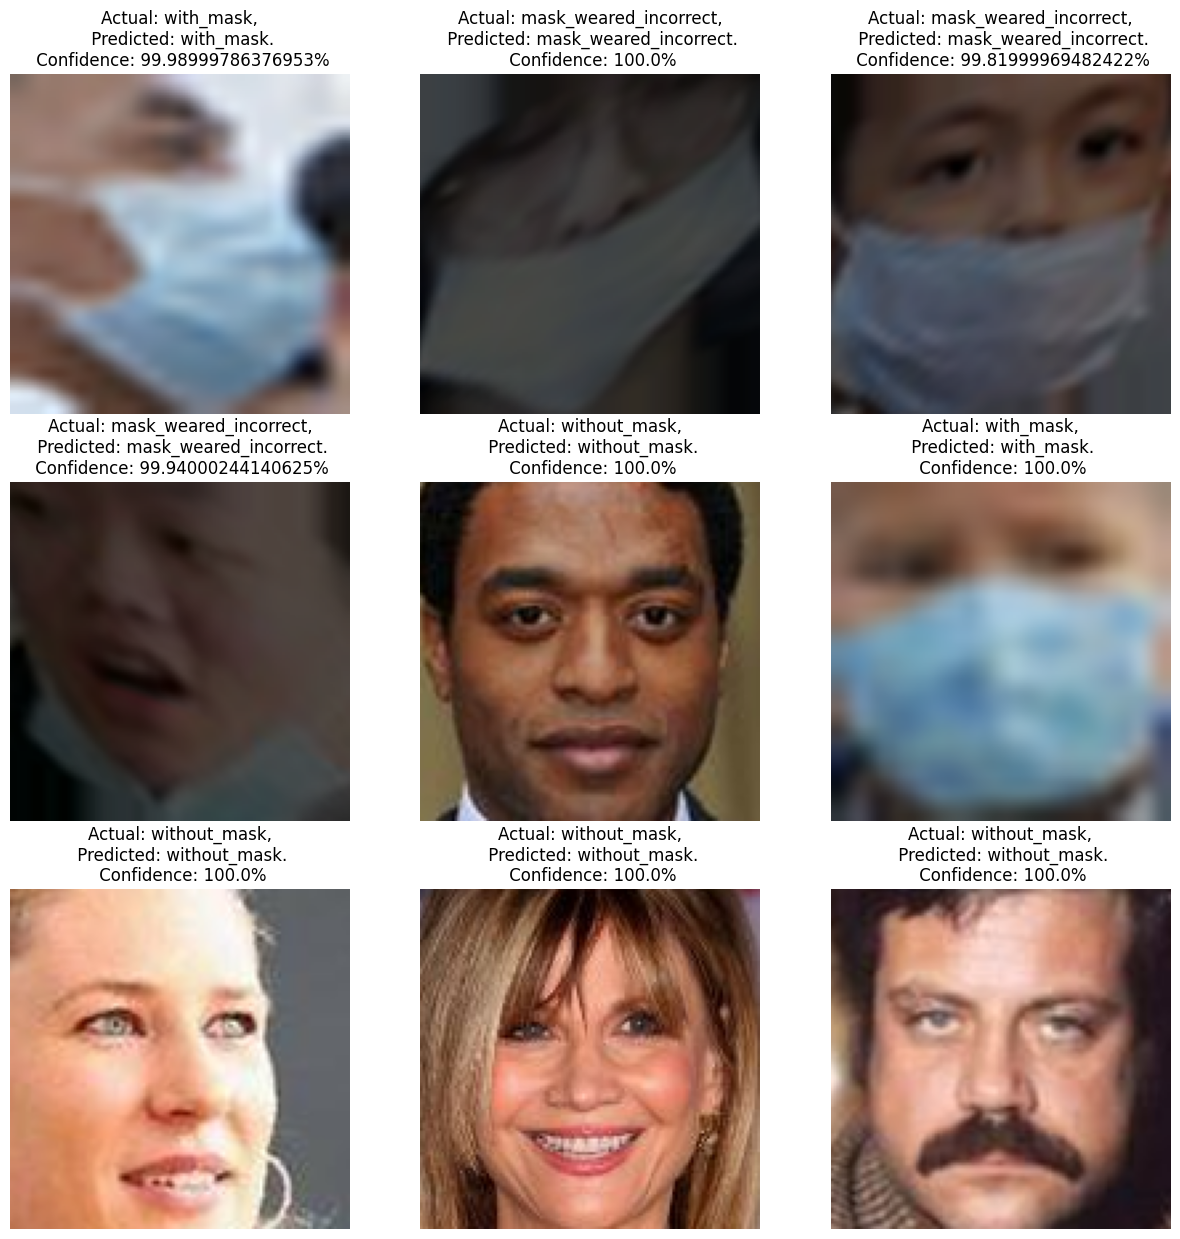

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Model Saving

What happens if I model.save() again locally ?
Nothing wrong happens.

It will just re-save the same trained model (weights + architecture) into a new .keras file.

We’re not “retraining”, just storing a copy of the model as it is at that moment.

Think of it like saving a Word file twice with different names, the content is the same unless you edit something in between.


In [272]:
# model.save("../models/1.keras")

# Important note about history

*history.pkl* contains only the logs (loss/accuracy curves).

It does not affect predictions or model saving.

It’s just for visualization after training.

When we re-save the model locally, that history is not automatically saved with it.

If we want, you need to save it separately with pickle again.